In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.interpolate import griddata
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import LogNorm

In [2]:
# Read PM2.5 and Ozone data
filepath = 'Datasets/daily_44201_2022.csv'
data = pd.read_csv(filepath)
pd.set_option('display.max_columns', None)

df = data[['Date Local', 'Latitude', 'Longitude', 'AQI']]
df.head(5)

,Date Local,Latitude,Longitude,AQI
0,2022-02-28,30.497478,-87.880258,35
1,2022-03-01,30.497478,-87.880258,50
2,2022-03-02,30.497478,-87.880258,51
3,2022-03-03,30.497478,-87.880258,40
4,2022-03-04,30.497478,-87.880258,77


In [3]:
# Read weather data
file2 = 'Datasets/3524590.csv'
data2 = pd.read_csv(file2)
df2 = data2[['DATE', 'LATITUDE', 'LONGITUDE', 'ELEVATION','PRCP','SNOW','SNWD','TMAX','TMIN']]
df2 = df2.rename(columns={"ELEVATION": "Elevation (weather)"})
df2.head(5)

,DATE,LATITUDE,LONGITUDE,Elevation (weather),PRCP,SNOW,SNWD,TMAX,TMIN
0,2022-03-01,44.4044,-123.7533,70.1,2.27,0.0,0.0,56.0,51.0
1,2022-03-02,44.4044,-123.7533,70.1,0.74,0.0,0.0,52.0,49.0
2,2022-03-03,44.4044,-123.7533,70.1,0.62,0.0,0.0,50.0,45.0
3,2022-03-04,44.4044,-123.7533,70.1,0.02,0.0,0.0,49.0,38.0
4,2022-03-05,44.4044,-123.7533,70.1,0.15,0.0,0.0,44.0,36.0


In [4]:
# Read Aeronet data
file3 = 'Datasets/aeronet2.csv'
df3 = pd.read_csv(file3)
df3 = df3.rename(columns={"Site_Elevation(m)": "Elevation (AERONET)"})
df3.head(5)

,Date,Latitude,Longitude,Elevation (AERONET),AOD_1640nm,AOD_1020nm,AOD_870nm,AOD_865nm,AOD_779nm,AOD_675nm,AOD_667nm,AOD_620nm,AOD_560nm,AOD_555nm,AOD_551nm,AOD_532nm,AOD_531nm,AOD_510nm,AOD_500nm,AOD_490nm,AOD_443nm,AOD_440nm,AOD_412nm,AOD_400nm,AOD_380nm,AOD_340nm,AOD_681nm,AOD_709nm
0,2022-12-30,-62.663056,-60.389444,5.0,0.049188,0.059211,0.062151,-999.0,-999.0,0.066013,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.073626,-999.0,-999.0,0.083497,-999.0,-999.0,0.079924,0.082425,-999.0,-999.0
1,2022-03-01,40.451900,-3.723950,680.0,-999.000000,0.050193,0.056500,-999.0,-999.0,0.067353,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.095629,-999.0,-999.0,0.115899,-999.0,-999.0,0.140979,0.151545,-999.0,-999.0
2,2022-03-02,40.451900,-3.723950,680.0,-999.000000,0.020488,0.023579,-999.0,-999.0,0.028519,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.040038,-999.0,-999.0,0.047169,-999.0,-999.0,0.058094,0.058613,-999.0,-999.0
3,2022-03-05,40.451900,-3.723950,680.0,-999.000000,0.033906,0.037883,-999.0,-999.0,0.044933,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.064754,-999.0,-999.0,0.079289,-999.0,-999.0,0.097636,0.102812,-999.0,-999.0
4,2022-03-06,40.451900,-3.723950,680.0,-999.000000,0.019403,0.023290,-999.0,-999.0,0.030635,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.045460,-999.0,-999.0,0.056093,-999.0,-999.0,0.069005,0.071608,-999.0,-999.0


In [5]:
# GRID PARAMETERS
degree = 0.5
# Step 1: Define grid boundaries and resolution
#on_min, lon_max = -125, -115 #CA
#lat_min, lat_max = 32, 42 #CA

lon_min, lon_max = -125, -70 #US
lat_min, lat_max = 32, 52 #US

#lon_min, lon_max = -180, 180 #US
#lat_min, lat_max = -90, 90 #US

#lon_min, lon_max = -25, 45 #EU
#lat_min, lat_max = 34, 72 #EU

#lon_min, lon_max = -5, 20 #EU land
#lat_min, lat_max = 40, 55 #EU land

nlon = int((lon_max-lon_min)/degree)
nlat = int((lat_max-lat_min)/degree)

lon_grid = np.linspace(lon_min, lon_max, nlon)
lat_grid = np.linspace(lat_min, lat_max, nlat)
lon_grid, lat_grid = np.meshgrid(lon_grid, lat_grid)

In [6]:
def assemble(combined_df,df,df2,df3,date,lon_min,lon_max,lat_min,lat_max,lon_grid,lat_grid):
    temp_df = pd.DataFrame()
    # Fit date for PM and Ozone data
    new_df = df[df['Date Local'] == date].copy()
    # Clean up PM2.5 and Ozone data
    new_df.reset_index(drop=True, inplace=True)
    new_df.drop(labels=['Date Local'], axis=1, inplace=True)
    new_df = new_df[new_df['AQI'] != 0]
    
    new_df['AQI'] = new_df['AQI'].apply(lambda x: np.log(x))
    
    # Interpolate PM2.5 and Ozone data onto the grid
    points = new_df[['Longitude', 'Latitude']].values
    lon = points[:, 0].astype(float)
    lat = points[:, 1].astype(float)
    pm25_values = new_df['AQI'].values
    pm25_grid = griddata(points, pm25_values, (lon_grid, lat_grid), method='nearest')
    
    # flatten pm and ozone data
    
    
    pm25_flat = pm25_grid.flatten()
    temp_df['AQI'] = pm25_flat
    
    # Fit date for weather data
    new_df2 = df2[df2['DATE'] == date].copy()
    
    # Clean up weather data
    new_df2 = new_df2.dropna(subset=['TMAX','TMIN','PRCP','SNOW','SNWD'])
    
    # weather interpolation 
    def MET_clean_int(df,col,lon_grid,lat_grid,met):
        points = df[['LONGITUDE', 'LATITUDE']].values
        lon = points[:, 0].astype(float)
        lat = points[:, 1].astype(float)
        values = df[col].values
        grid = griddata(points, values, (lon_grid, lat_grid), method=met)
        return grid
    
    # flatten weather data
    met_var = ['Elevation (weather)','PRCP','SNOW','SNWD','TMAX','TMIN']
    for i in range(len(met_var)):
        grid = MET_clean_int(new_df2,met_var[i],lon_grid,lat_grid,'nearest')
        flat = grid.flatten()
        temp_df[met_var[i]] = flat
    
    # Fit date for aeronet data
    new_df3 = df3[df3['Date'] == date].copy()
    
    # Aeronet interpolation
    def AOD_clean_int(df,col,lon_grid,lat_grid,met):
        new_df = df[df[col] != -999.000]
        points = new_df[['Longitude', 'Latitude']].values
        lon = points[:, 0].astype(float)
        lat = points[:, 1].astype(float)
        values = new_df[col].values
        grid = griddata(points, values, (lon_grid, lat_grid), method=met)
        return grid
    
    # flatten aeronet data
    aeronet_var = [
        'Elevation (AERONET)', 'AOD_1640nm','AOD_1020nm', 'AOD_870nm',  'AOD_675nm', 'AOD_500nm', 
        'AOD_440nm', 'AOD_380nm','AOD_340nm'
    ]
    for i in range(len(aeronet_var)):
        grid = AOD_clean_int(new_df3,aeronet_var[i],lon_grid,lat_grid,'nearest')
        flat = grid.flatten()
        temp_df[aeronet_var[i]] = flat

    frames = [combined_df,temp_df]
    combined_df = pd.concat(frames)

    if date == '2022-03-01':
        fig, ax = plt.subplots(figsize=(20, 8), subplot_kw={'projection': ccrs.PlateCarree()})
        ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
        cax = ax.pcolormesh(lon_grid, lat_grid, pm25_grid, cmap='viridis', shading='auto', transform=ccrs.PlateCarree())
        #plt.scatter(lon, lat)
        ax.add_feature(cfeature.COASTLINE)
        cbar = fig.colorbar(cax)
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        #ax.set_title('Interpolated Daily Average log(PM2.5) using Nearest Method')
        #plt.savefig('nearest_CA.jpg', dpi=300)
        plt.show()

        tmax_grid = MET_clean_int(new_df2,'TMAX',lon_grid,lat_grid,'nearest')
        fig, ax = plt.subplots(figsize=(20, 8), subplot_kw={'projection': ccrs.PlateCarree()})
        ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
        cax = ax.pcolormesh(lon_grid, lat_grid, tmax_grid, cmap='viridis', shading='auto', transform=ccrs.PlateCarree())
        #plt.scatter(lon, lat)
        ax.add_feature(cfeature.COASTLINE)
        cbar = fig.colorbar(cax)
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        #ax.set_title('Interpolated Daily Maximum Temperature using Nearest Method')
        #plt.savefig('nearest_CA.jpg', dpi=300)
        plt.show()

        aod_grid = AOD_clean_int(new_df3,'AOD_870nm',lon_grid,lat_grid,'nearest')
        fig, ax = plt.subplots(figsize=(20, 8), subplot_kw={'projection': ccrs.PlateCarree()})
        ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
        cax = ax.pcolormesh(lon_grid, lat_grid, aod_grid, cmap='viridis', shading='auto', transform=ccrs.PlateCarree())
        #plt.scatter(lon, lat)
        ax.add_feature(cfeature.COASTLINE)
        cbar = fig.colorbar(cax)
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        #ax.set_title('Interpolated AOD at 870 nm using Nearest Method')
        #plt.savefig('nearest_CA.jpg', dpi=300)
        plt.show()
        
    return combined_df

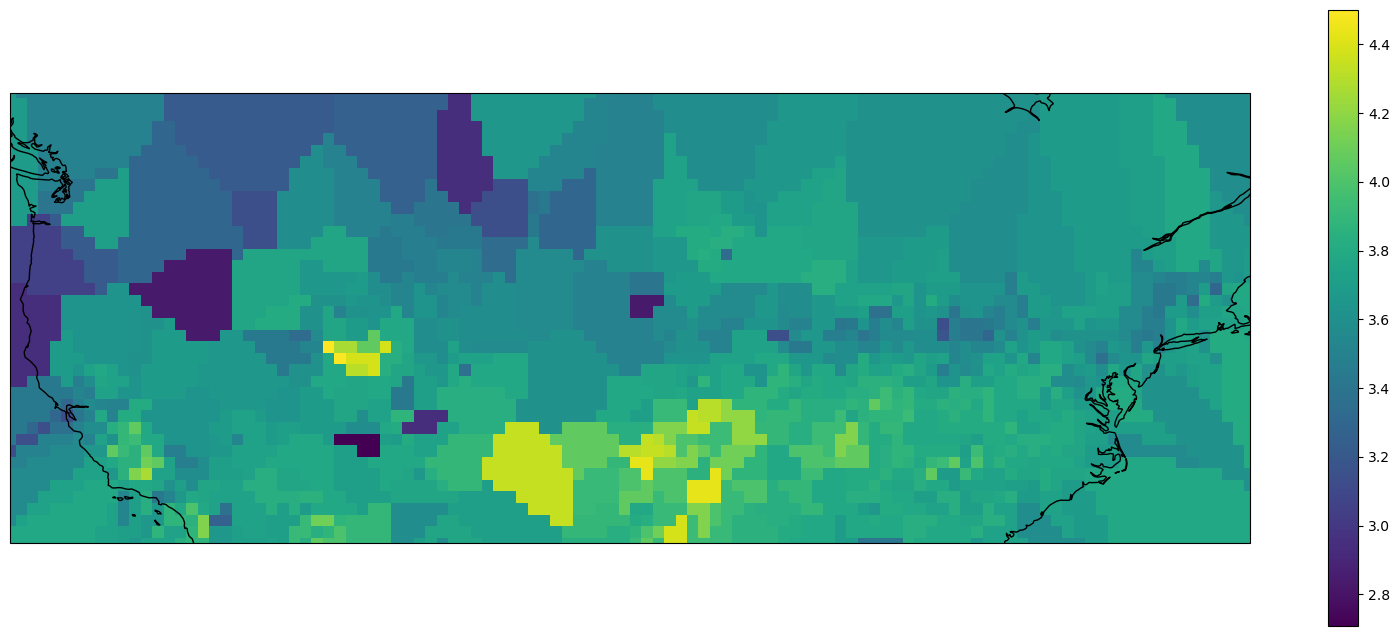

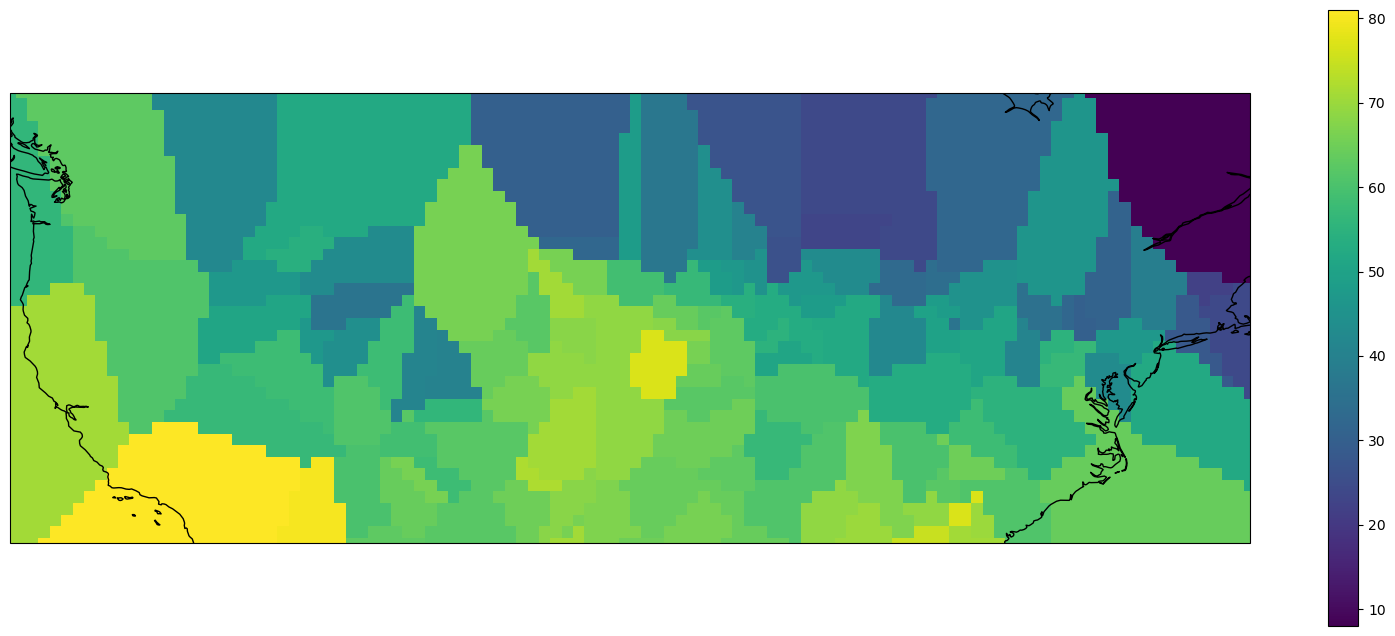

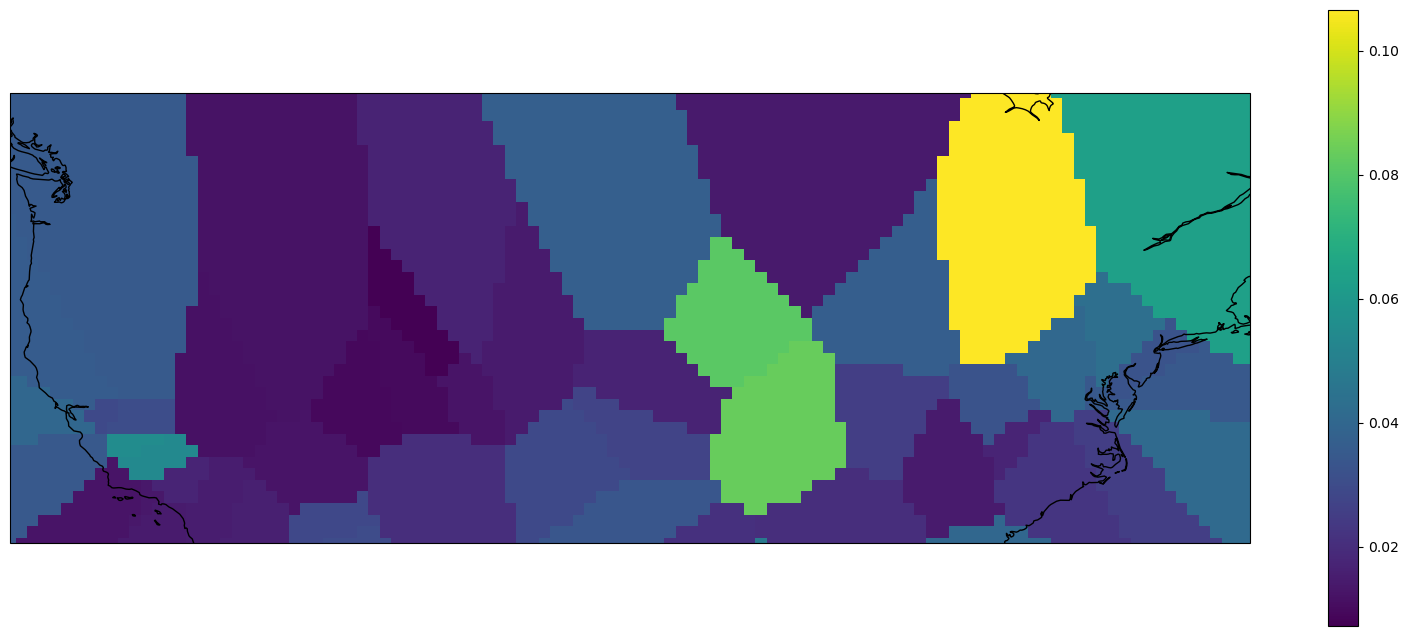

In [7]:
start_date = '2022-03-01'
end_date = '2022-05-01'
dates = pd.date_range(start=start_date, end=end_date)
dates = [d.date() for d in dates]
date_list = [d.strftime('%Y-%m-%d') for d in dates]
combined_df = pd.DataFrame()

for date in date_list:
    combined_df = assemble(combined_df,df,df2,df3,date,lon_min,lon_max,lat_min,lat_max,lon_grid,lat_grid)

In [8]:
combined_df.describe()

,AQI,Elevation (weather),PRCP,SNOW,SNWD,TMAX,TMIN,Elevation (AERONET),AOD_1640nm,AOD_1020nm,AOD_870nm,AOD_675nm,AOD_500nm,AOD_440nm,AOD_380nm,AOD_340nm
count,272800.000000,272800.000000,272800.000000,272800.000000,272800.000000,272800.000000,272800.000000,272800.000000,272800.000000,272800.000000,272800.000000,272800.000000,272800.000000,272800.000000,272800.000000,272800.000000
mean,3.671220,634.911407,0.084096,0.124856,1.239775,55.508941,31.687848,630.146989,0.035964,0.051996,0.058227,0.072020,0.098856,0.113137,0.129516,0.140808
std,0.203017,629.163475,0.239985,0.639336,4.540302,16.191569,13.564992,660.764261,0.029118,0.034647,0.037557,0.045898,0.062943,0.072533,0.086426,0.096469
min,0.693147,1.200000,0.000000,0.000000,0.000000,8.000000,-34.000000,-32.000000,-0.002763,0.004974,0.005876,0.005940,0.009877,0.013738,0.013624,0.011249
25%,3.583519,183.800000,0.000000,0.000000,0.000000,44.000000,24.000000,186.000000,0.015336,0.027362,0.031255,0.040188,0.056383,0.064412,0.071326,0.076389
50%,3.688879,396.500000,0.000000,0.000000,0.000000,55.000000,31.000000,373.440000,0.027958,0.042280,0.047775,0.059227,0.081134,0.092278,0.104479,0.112596
75%,3.784190,932.700000,0.030000,0.000000,0.000000,67.000000,40.000000,808.000000,0.047737,0.068086,0.075762,0.091700,0.124078,0.140639,0.160992,0.174667
max,5.010635,2724.600000,3.500000,20.000000,80.000000,100.000000,71.000000,3376.000000,0.306340,0.324715,0.374396,0.500045,0.714082,0.811168,0.929410,1.008788


In [9]:
combined_df.head(5)

,AQI,Elevation (weather),PRCP,SNOW,SNWD,TMAX,TMIN,Elevation (AERONET),AOD_1640nm,AOD_1020nm,AOD_870nm,AOD_675nm,AOD_500nm,AOD_440nm,AOD_380nm,AOD_340nm
0,3.78419,527.0,0.0,0.0,0.0,71.0,37.0,50.0,0.027825,0.033055,0.034693,0.035636,0.042980,0.049442,0.053372,0.048359
1,3.78419,527.0,0.0,0.0,0.0,71.0,37.0,33.0,0.027825,0.010138,0.012280,0.013081,0.020905,0.027062,0.029704,0.031415
2,3.78419,527.0,0.0,0.0,0.0,71.0,37.0,33.0,0.027825,0.010138,0.012280,0.013081,0.020905,0.027062,0.029704,0.031415
3,3.78419,393.2,0.0,0.0,0.0,81.0,43.0,33.0,0.027825,0.010138,0.012280,0.013081,0.020905,0.027062,0.029704,0.031415
4,3.78419,393.2,0.0,0.0,0.0,81.0,43.0,33.0,0.027825,0.010138,0.012280,0.013081,0.020905,0.027062,0.029704,0.031415


In [10]:
combined_df = combined_df[['AQI','Elevation (weather)','PRCP','TMAX','TMIN']]

In [11]:
combined_df.head(5)

,AQI,Elevation (weather),PRCP,TMAX,TMIN
0,3.78419,527.0,0.0,71.0,37.0
1,3.78419,527.0,0.0,71.0,37.0
2,3.78419,527.0,0.0,71.0,37.0
3,3.78419,393.2,0.0,81.0,43.0
4,3.78419,393.2,0.0,81.0,43.0


In [12]:
from sklearn.model_selection import train_test_split

target = 'AQI'

X_data=combined_df.drop([target],axis=1).values
y_data=combined_df[target].values
y_data = y_data.reshape(-1,1)

test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=test_size)

print("shape of X_train:")
print("", X_train.shape)
print("shape of y_train:")
print("", y_train.shape)
print()
print("shape of X_test:")
print("", X_test.shape)
print("shape of y_test:")
print("", y_test.shape)
print()

shape of X_train:
 (190960, 4)
shape of y_train:
 (190960, 1)

shape of X_test:
 (81840, 4)
shape of y_test:
 (81840, 1)



In [13]:
# REC curve
def rec(m, n, tol):
    if not type(m) == 'numpy.ndarray':
        m = np.array(m) #change m to a np array
    if not type(n) == 'numpy.ndarray':
        n = np.array(n) #change n to a np array

    l = m.size
    percent = 0
    for i in range(l):
        #if np.abs(10**m[i]-10**n[i])<=tol:
        #if abs(n[i] - m[i])**2 <= tol/100:
        #if abs(n[i] - m[i])/n[i] <= tol/100:
        if max(0, abs(n[i] - m[i])-tol/100 ) <= tol/100:
            percent+=1
    return 100*(percent/l)

In [14]:
# Linear
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

pipe = Pipeline([('scaler', StandardScaler()), ('lr', Ridge(alpha=1.0))])
pipe.fit(X_train, y_train)
y_pred_lr = pipe.predict(X_test)

In [15]:
print("RMSE for linear regression (with scaling):", np.sqrt(np.mean((y_test-y_pred_lr)**2)))
print()

tol_max = 50
rec_linear=[]

for i in range(tol_max):
    rec_linear.append(rec(y_pred_lr, y_test, i))

RMSE for linear regression (with scaling): 0.1910836883729991



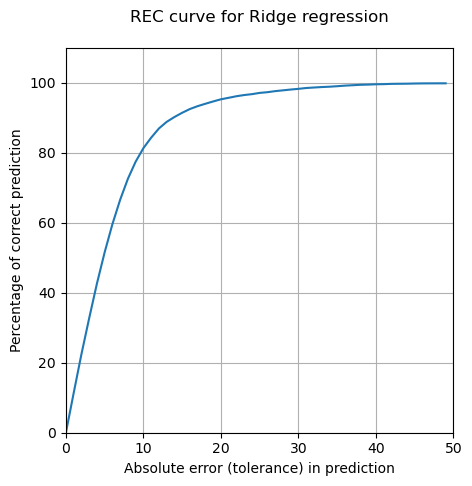

In [16]:
plt.figure(figsize=(5,5))
plt.title("REC curve for Ridge regression\n")
plt.xlabel("Absolute error (tolerance) in prediction")
plt.ylabel("Percentage of correct prediction")
plt.xticks([i*5 for i in range(tol_max+1)])
plt.ylim(-10,100)
plt.yticks([i*20 for i in range(6)])
plt.grid(True)
plt.plot(range(tol_max),rec_linear, label='linear')
#plt.legend()
plt.ylim(0, 110)
plt.xlim(0, 50)
#plt.xticks([0,20,40,60,80,100])
plt.xticks([0,10,20,30,40,50])
plt.yticks([0,20,40,60,80,100])
plt.show()

In [17]:
# Decision Tree
from sklearn.tree import DecisionTreeRegressor

pipe2 = Pipeline([('scaler', StandardScaler()), ('regressor', DecisionTreeRegressor())])
pipe2.fit(X_train, y_train)
y_pred_tree = pipe2.predict(X_test)

In [18]:
print("RMSE for decision tree (with scaling):", np.sqrt(np.mean((y_test-y_pred_tree)**2)))
print()

# Decision Tree
rec_tree=[]

for i in range(tol_max):
    rec_tree.append(rec(y_pred_tree, y_test, i))

RMSE for decision tree (with scaling): 0.2622639442608284



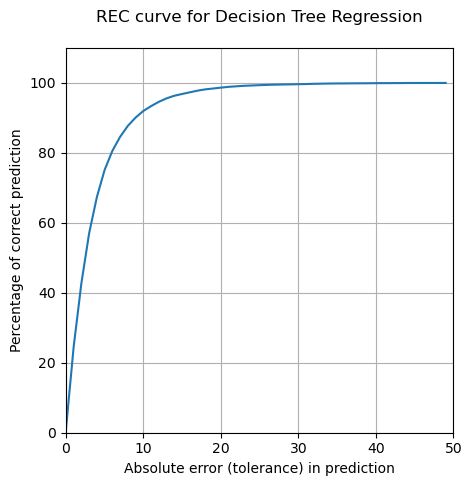

In [19]:
plt.figure(figsize=(5,5))
plt.title("REC curve for Decision Tree Regression\n")
plt.xlabel("Absolute error (tolerance) in prediction")
plt.ylabel("Percentage of correct prediction")
plt.xticks([i*5 for i in range(tol_max+1)])
plt.ylim(-10,100)
plt.yticks([i*20 for i in range(6)])
plt.grid(True)
#plt.plot(range(tol_max),rec_linear, label='linear')
plt.plot(range(tol_max),rec_tree)
#plt.legend()
plt.ylim(0, 110)
plt.xlim(0, 50)
#plt.xticks([0,20,40,60,80,100])
plt.xticks([0,10,20,30,40,50])
plt.yticks([0,20,40,60,80,100])
plt.show()

Text(0, 0.5, 'Feature Importance')

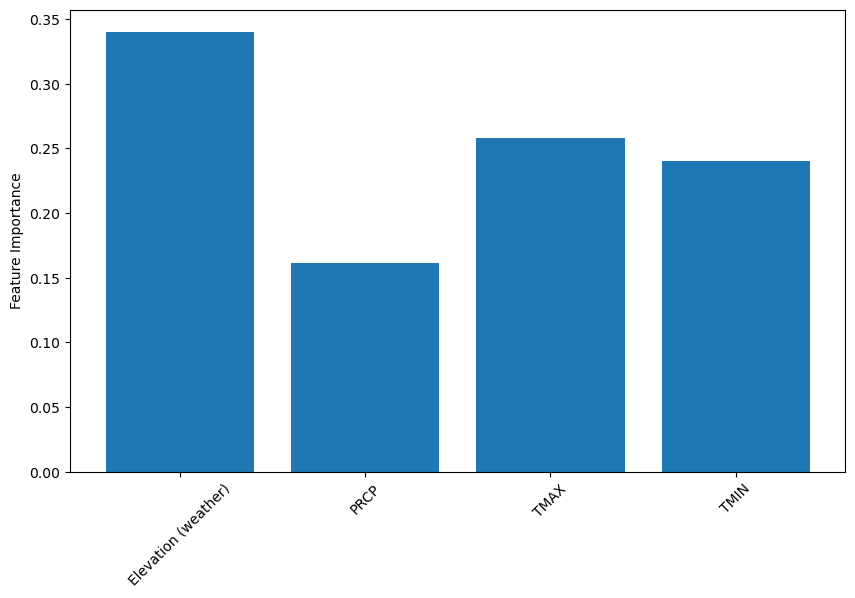

In [20]:
tree = pipe2.named_steps['regressor']
importances = tree.feature_importances_
feature_list = combined_df.drop([target],axis=1).columns.tolist()
plt.figure(figsize=(10, 6))
plt.bar(feature_list, importances)
plt.xticks(rotation=45)
plt.ylabel("Feature Importance")

In [21]:
# ANN
from sklearn.neural_network import MLPRegressor

ann = MLPRegressor(hidden_layer_sizes=(15,10,8,5))
pipe3 = Pipeline([('scaler', StandardScaler()), ('mlp', ann)])
pipe3.fit(X_train, y_train)
y_pred_ann = pipe3.predict(X_test)


/home/junbo-wang/miniconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1625: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [22]:
print("RMSE for neural network (with scaling):", np.sqrt(np.mean((y_test-y_pred_ann)**2)))

rec_ann=[]

for i in range(tol_max):
    rec_ann.append(rec(y_pred_ann, y_test, i))


RMSE for neural network (with scaling): 0.22352112798853688


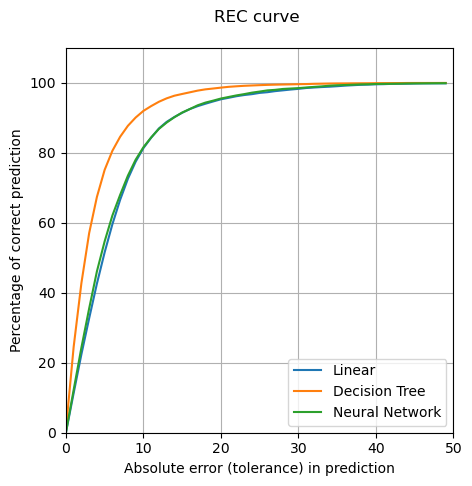

In [23]:
plt.figure(figsize=(5,5))
plt.title("REC curve \n")
plt.xlabel("Absolute error (tolerance) in prediction")
plt.ylabel("Percentage of correct prediction")
plt.xticks([i*5 for i in range(tol_max+1)])
plt.ylim(-10,100)
plt.yticks([i*20 for i in range(6)])
plt.grid(True)
plt.plot(range(tol_max),rec_linear, label='Linear')
plt.plot(range(tol_max),rec_tree, label='Decision Tree')
plt.plot(range(tol_max),rec_ann, label='Neural Network')
plt.legend()
plt.ylim(0, 110)
plt.xlim(0, 50)
#plt.xticks([0,20,40,60,80,100])
plt.xticks([0,10,20,30,40,50])
plt.yticks([0,20,40,60,80,100])
plt.show()

In [24]:
# Ensemble
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error


# Create the individual models
model1 = LinearRegression()
model2 = RandomForestRegressor(n_estimators=50, random_state=42)
model3 = GradientBoostingRegressor(random_state=42)
model4 = DecisionTreeRegressor()

# Create the ensemble model
voting_regressor = VotingRegressor(estimators=[
    ('lr', model1),
    ('rf', model2),
    ('gbr', model3),                              
    ('dt', model4),   
])

voting_regressor.fit(X_train, y_train)
# Make predictions
y_pred_ens = voting_regressor.predict(X_test)

/home/junbo-wang/miniconda3/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:604: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [25]:
print("RMSE for ensemble (with scaling):", np.sqrt(np.mean((y_test-y_pred_ens)**2)))

rec_ens=[]

for i in range(tol_max):
    rec_ens.append(rec(y_pred_ens, y_test, i))

RMSE for ensemble (with scaling): 0.23052960668127181


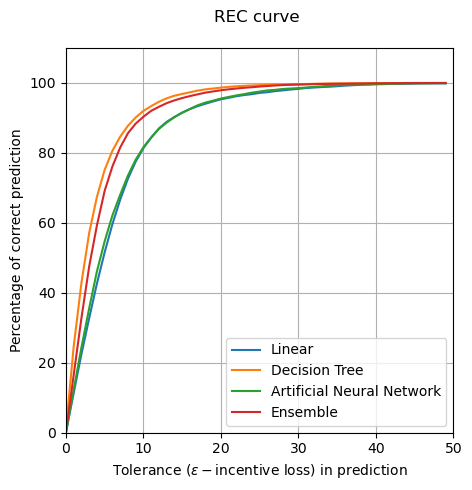

In [26]:
plt.figure(figsize=(5,5))
plt.title("REC curve \n")
plt.xlabel("Tolerance ($\epsilon-$incentive loss) in prediction")
plt.ylabel("Percentage of correct prediction")
plt.xticks([i*5 for i in range(tol_max+1)])
plt.ylim(-10,100)
plt.yticks([i*20 for i in range(6)])
plt.grid(True)
plt.plot(range(tol_max),rec_linear, label='Linear')
plt.plot(range(tol_max),rec_tree, label='Decision Tree')
plt.plot(range(tol_max),rec_ann, label='Artificial Neural Network')
plt.plot(range(tol_max),rec_ens, label='Ensemble')
plt.legend()
plt.ylim(0, 110)
plt.xlim(0, 50)
#plt.xticks([0,20,40,60,80,100])
plt.xticks([0,10,20,30,40,50])
plt.yticks([0,20,40,60,80,100])
plt.show()

In [27]:
std = np.std(y_data)
print(std)

0.20301644007584446
